In [1]:
default_augmentations = {
    "random_crop": {
        "size": (72, 72, 72),
        "p": 1.0
    },
    "random_flip": {
        "p": 0.25
    },
    "random_axes_transpose": {
        "p": 0.1
    },
    "random_channel_gauss": {
        "mean" : 0, 
        "std" : 1, 
        "channels" : 4,
        "p": 0.2
    }
}

In [2]:
from dataset import ClearBRATS

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'

# Create a non-augmented clear dataset
clear_dataset = ClearBRATS(data_dir=data_dir)
clear_dataset[0][0].shape

(4, 240, 240, 155)

Clean image:


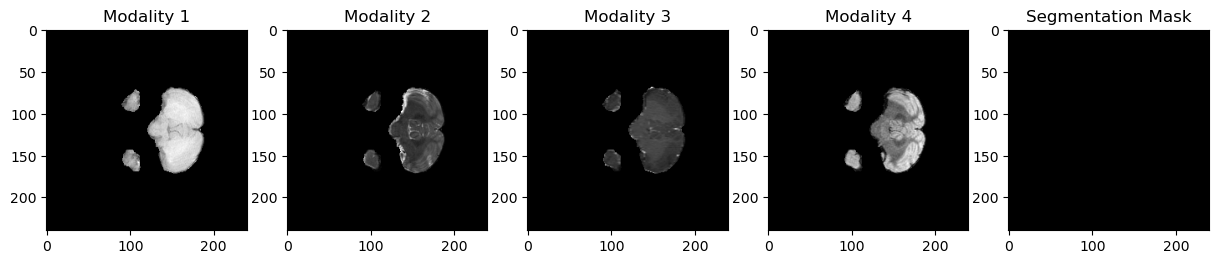

Normalized:


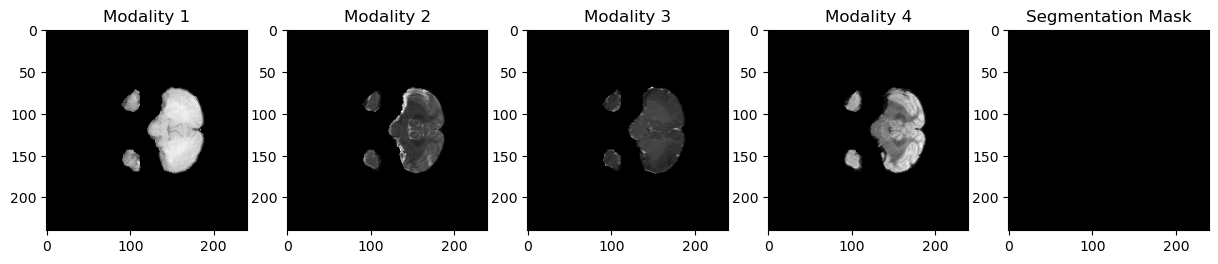

One-hot channel added:


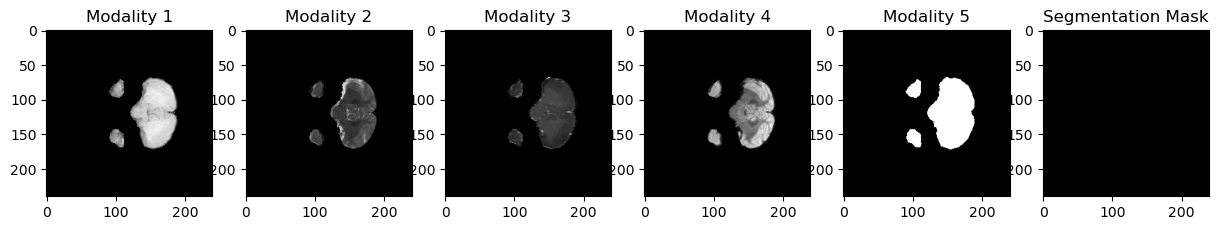

Cropped all the full-zero layers:


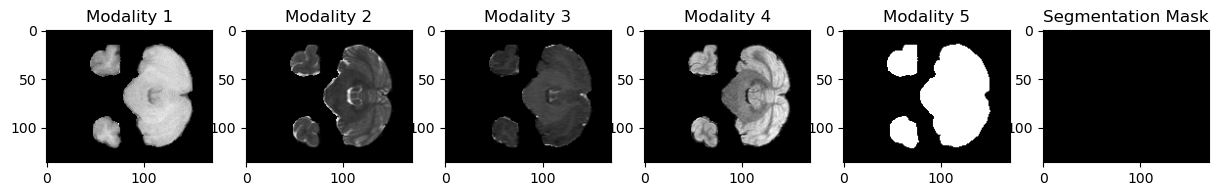

Augmentations added:


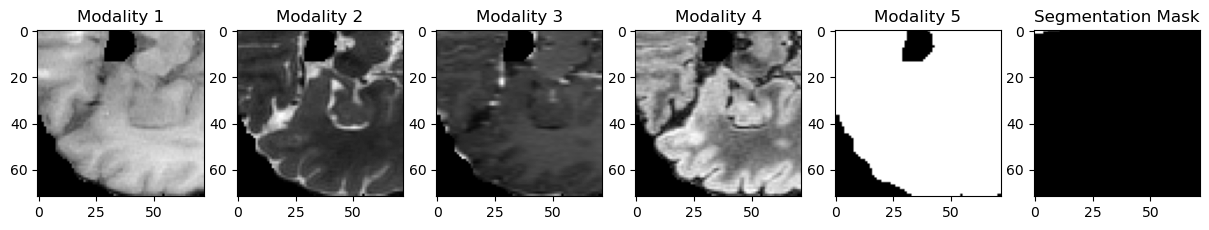

In [18]:
from dataset import BRATS

my_dataset = BRATS(dataset=clear_dataset, normalized=False, add_onehot=False, is_cropped=False)
print("Clean image:")
my_dataset.slice_display(0, slice_num = 30)

print("Normalized:")
my_dataset.normalized = True
my_dataset.slice_display(0, slice_num = 30)

print("One-hot channel added:")
my_dataset.add_onehot = True
my_dataset.slice_display(0, slice_num = 30)

print("Cropped all the full-zero layers:")
my_dataset.is_cropped = True
my_dataset.slice_display(0, slice_num = 30)

print("Augmentations added:")
my_dataset.augmentation_config = default_augmentations
my_dataset.slice_display(0, slice_num = 30)

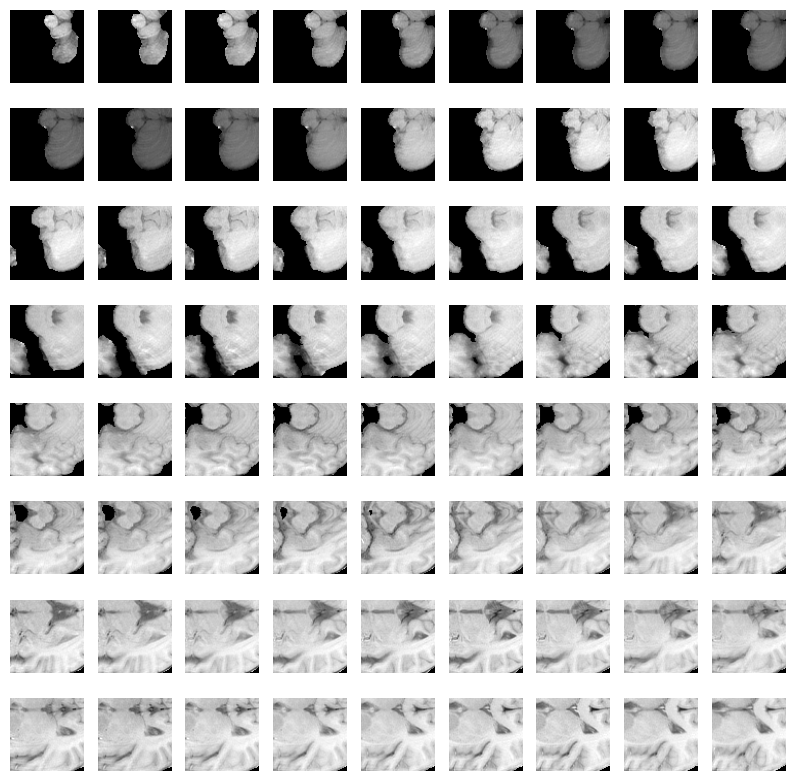

In [19]:
# Montage display
my_dataset.montage_display(0)

In [15]:
# Fast initialization of train-test datasets
from dataset import init_train_test_datasets

train_dataset, test_dataset = init_train_test_datasets(data_dir, train_ratio = 0.8, normalized=True, is_cropped=True, add_onehot=True, augmentation_config=default_augmentations, add_test_augmentations=False)

print(len(train_dataset), len(test_dataset))

1000 251


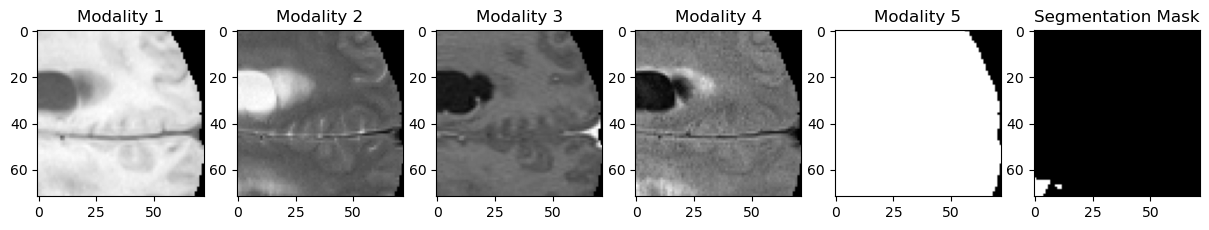

In [16]:
train_dataset.slice_display(0, slice_num=30, figsize=(15,5))

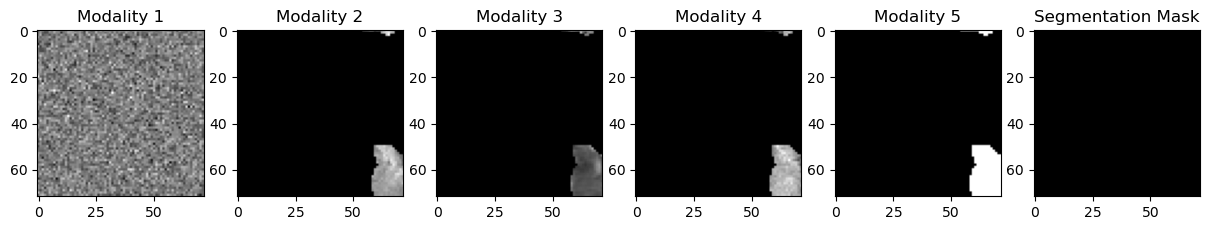

In [8]:
train_dataset.slice_display(0, slice_num = 0)